# Reconstructing a spherically symmetric model
---

In [2]:
import matplotlib.pyplot as plt
import numpy             as np

from tqdm                 import tqdm
from astropy              import units, constants

from p3droslo.utils       import convert_angular_to_spatial
from p3droslo.plot        import plot_cube_2D
from p3droslo.object      import AstroObject
from p3droslo.observation import DataCube

from p3droslo.model       import TensorModel, SphericallySymmetric
from p3droslo.utils       import print_var, interpolate
from p3droslo.lines       import Line
from p3droslo.loss        import Loss, fourier_loss_1D, fourier_loss_1D

In [3]:
obj = AstroObject('IK Tau')

Using the parallax distance.


In [4]:
file = '/STER/frederikd/Deprojection/data/observations/IKTau_CO3-2.fits'
dat  = DataCube(file)

In [5]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=30, description='f', max=60), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [6]:
# Integrate over each channel map
I = np.sum(dat.img.astype(np.float64), axis=(1,2))

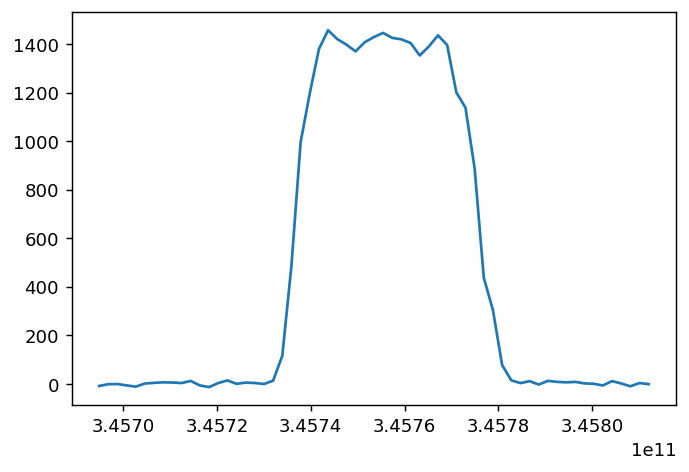

In [7]:
plt.figure(dpi=130)
plt.plot(dat.fs, I)

In [8]:
angle_x = abs(dat.npix_x * dat.pixsize_x)
angle_y = abs(dat.npix_y * dat.pixsize_y)

size_x = convert_angular_to_spatial(angle_x, obj.distance)
size_y = convert_angular_to_spatial(angle_y, obj.distance)
size_z = max(size_x, size_y)

size_x = size_x.to(units.m).value
size_y = size_y.to(units.m).value
size_z = size_z.to(units.m).value

shape = (128, 128, 128)

In [9]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim      import Adam, LBFGS

In [10]:
# Model Hyperparameters
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [11]:
obs = I     .astype(np.float64)
fqs = dat.fs.astype(np.float64)

obs = torch.from_numpy(obs)
fqs = torch.from_numpy(fqs)

# Crop data
obs = obs[15:49]
fqs = fqs[15:49]

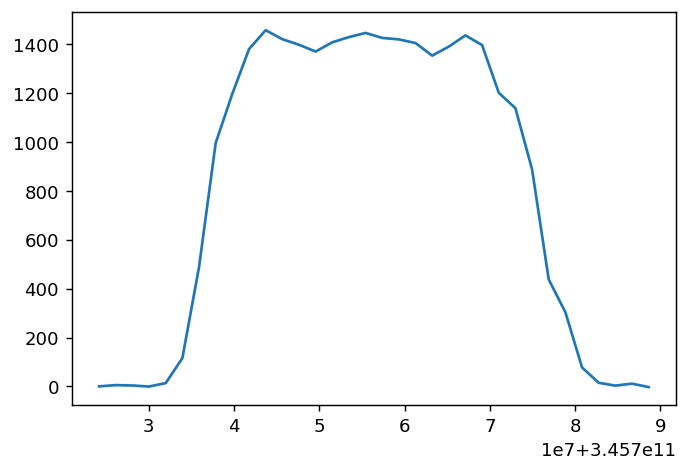

In [12]:
plt.figure(dpi=130)
plt.plot(fqs, obs)

In [13]:
line = Line('CO', 2)

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


log_v_turbulence     tensor([6.2146], dtype=torch.float64)
log_v_los            tensor([10.4341], dtype=torch.float64)
log_M                tensor([69.7649], dtype=torch.float64)


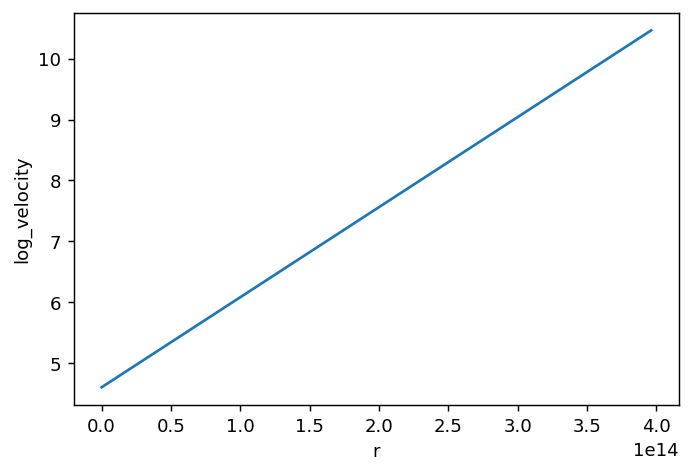

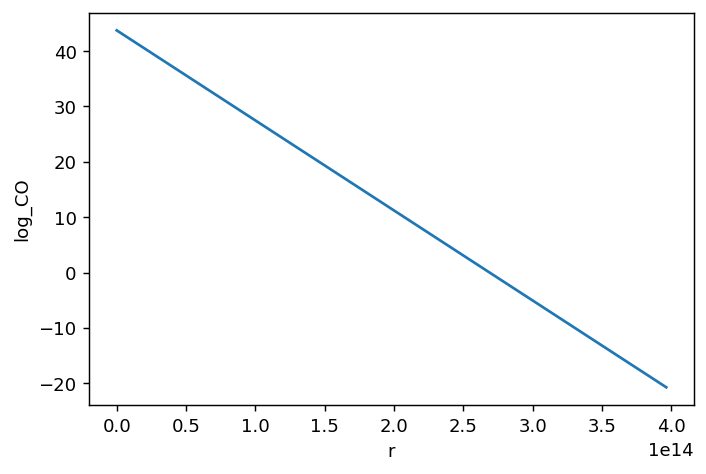

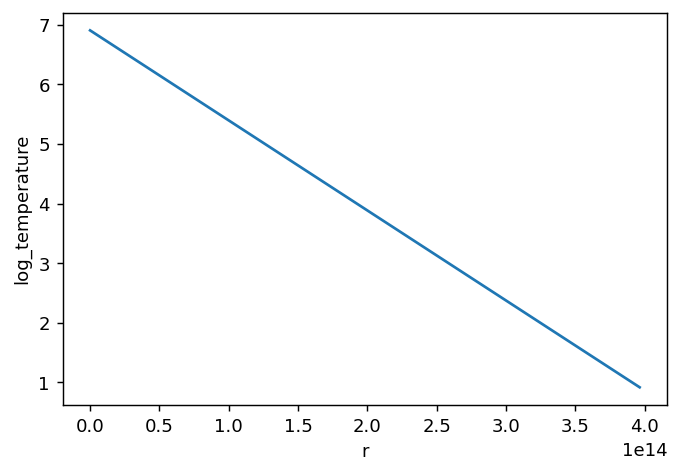

In [41]:
# Create a 1D TensorModel
model_1D = TensorModel(sizes=size_x, shape=128)

# Define and initialise the model variables
model_1D['log_velocity'    ] = np.linspace(np.log(1.0e+2 ), np.log(3.5e+4), model_1D.shape[0], dtype=np.float64)
model_1D['log_CO'          ] = np.linspace(np.log(1.0e+19), np.log(1.0e-9), model_1D.shape[0], dtype=np.float64)
model_1D['log_temperature' ] = np.linspace(np.log(1.0e+3 ), np.log(2.5e+0), model_1D.shape[0], dtype=np.float64)

model_1D['log_v_turbulence'] = np.array([np.log(5.0e+2)])
model_1D['log_v_los'       ] = np.array([np.log(3.4e+4)])
model_1D['log_M'           ] = np.array([np.log(constants.M_sun.si.value)])

# Explicitly set all model variables free (i.e. all will be fitted)
model_1D.free_all()

# model_1D.fix('log_M')

# Create a spherically symmetric model form the 1D TensorModel
spherical = SphericallySymmetric(model_1D)

# Extract the projection cosine along the line of sight
direction = spherical.model_2D.get_radial_direction()[0]

# loss = Loss(['rep', 'reg', 'hyd'])
# loss = Loss(['reg', 'hyd'])
loss = Loss(['rep', 'reg', 'hyd_con', 'hyd_mom', 'hyd_eng'])

spherical.plot()

In [42]:
model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_velocity               Free          True     +4.605e+00     +7.534e+00     +1.046e+01
  log_CO                     Free          True     -2.072e+01     +1.151e+01     +4.375e+01
  log_temperature            Free          True     +9.163e-01     +3.912e+00     +6.908e+00
  log_v_turbulence           Free          False    +6.215e+00     +6.215e+00     +6.215e+00
  log_v_los                  Free          False    +1.043e+01     +1.043e+01     +1.043e+01
  log_M                      Free          False    +6.976e+01     +6.976e+01     +6.976e+01
sizes: (399385284171406.56,)
shape: (128,)


In [43]:
from astropy import constants

CC  = constants.c  .si.value   # Speed of light       [m/s]

def get_doppler_shifted_frequencies(v_los, frequencies):
    """
    """
    
    # Compute the Doppler shift for each cell
    shift = 1.0 + v_los * (1.0 / CC)

    # Create freqency tensor for each cell
    freqs = torch.einsum("..., f -> ...f", shift, frequencies)
    
    return freqs

In [44]:
def forward(spherical):
    
    spherical.map_1D_to_2D()

    nCO    = torch.exp(spherical.model_2D['log_CO'])         
    tmp    = torch.exp(spherical.model_2D['log_temperature'])
    vel    = torch.exp(spherical.model_2D['log_velocity'])
    v_turb = torch.exp(spherical.model_1D['log_v_turbulence'])
    v_los  = torch.exp(spherical.model_1D['log_v_los'])
    
    frequencies = get_doppler_shifted_frequencies(vel*direction + v_los, fqs)

    # Compute the LTE line emissivity and opacity, and the line profile
    eta, chi = line.LTE_emissivity_and_opacity(nCO, tmp, v_turb, frequencies)
    
    # Create an image of the line
    img = spherical.model_2D.create_image(eta, chi, axis=0)
    
    # Convolve with beam
    # img = convolve_with_beam(img)
    
    # Resolved out flux
    # img = resolved_out_flux(img)
    
    # Compute the integrated line intensity
    I = spherical.integrate_intensity(img)
    
    return I

In [45]:
gamma = 1.2
mu    = 2.381 * constants.u.si.value

def steady_state_hydrodynamic_loss(spherical, f_r=0.0, heating_m_cooling=0.0):
    """
    Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
    """
    r = torch.from_numpy(spherical.model_1D.get_coords())
    r[0] = (r[1]/r[2]) * r[1]

    log_rho = spherical.model_1D['log_CO']
    log_tmp = spherical.model_1D['log_temperature'] 
    log_v_r = spherical.model_1D['log_velocity']
    log_M   = spherical.model_1D['log_M']

    rho = torch.exp(log_rho)         
    tmp = torch.exp(log_tmp)
    v_r = torch.exp(log_v_r)
    M   = torch.exp(log_M)
    
    kBT_o_mu = (constants.k_B.si.value / mu) * tmp

    f_r = -constants.G.si.value * M / r**2

    # Energy    
    eng = 0.5 * v_r**2 + (gamma / (gamma - 1.0)) * kBT_o_mu

    # log rho + log T
    log_rho_p_log_tmp = log_rho + log_tmp

    # Continuity equation (steady state): div(ρ v) = 0
    loss_cont = spherical.model_1D.diff_x(r**2 * rho * v_r)

    # Momentum equation (steady state): v . grad(v) + grad(P) / rho = F / rho
    loss_momr = spherical.model_1D.diff_x(v_r) * v_r + kBT_o_mu * spherical.model_1D.diff_x(log_rho_p_log_tmp) - f_r

    # Energy equation (steady state): div((E + P) v) - Λ = 0
    loss_engy = rho * v_r * spherical.model_1D.diff_x(eng) - heating_m_cooling

    # Compute the mean squared losses
    losses = torch.stack([
        ((loss_cont/(r**2*rho))**2),
        ((loss_momr/(     v_r))**2),
        ((loss_engy/( rho*eng))**2)
    ])

    # Return losses
    return losses

In [46]:
f_rep = nn.functional.mse_loss(forward(spherical), obs).item()
f_rep

1043224.6542493822

In [47]:
f_reg = spherical.model_1D.apply(fourier_loss_1D).item()
f_reg

2452588.75

In [48]:
L_con, L_mom, L_eng = steady_state_hydrodynamic_loss(spherical)

f_con = L_con.mean().item()
f_mom = L_mom.mean().item()
f_eng = L_eng.mean().item()

print(f_con, f_mom, f_eng)

2.4506818558482246e-18 2.397414634452766e-15 9.350038162306045e-20


In [49]:
def fit(N_epochs=100, lr=1.0e-1, w_rep=1.0, w_reg=1.0, w_hyd=1.0, w_con=1.0, w_mom=1.0, w_eng=1.0):

    optimizer = Adam(model_1D.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        I = forward(spherical)
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * nn.functional.mse_loss(I, obs)
        # Compute the regularisation loss
        loss['reg'] = w_reg * spherical.model_1D.apply(fourier_loss_1D)
        # Compute the steady state hydrodynamic loss

        L_con, L_mom, L_eng = steady_state_hydrodynamic_loss(spherical)

        loss['hyd_con'] = w_con * L_con.mean()
        loss['hyd_mom'] = w_mom * L_mom.mean()
        loss['hyd_eng'] = w_eng * L_eng.mean()
    
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

    # Plot final model and data
    plt.figure(dpi=130)
    plt.plot(fqs, I.data)
    plt.plot(fqs, obs.data)

100%|██████████| 500/500 [00:14<00:00, 35.51it/s]


log_v_turbulence     tensor([8.7395], dtype=torch.float64)
log_v_los            tensor([10.4473], dtype=torch.float64)
log_M                tensor([66.4518], dtype=torch.float64)


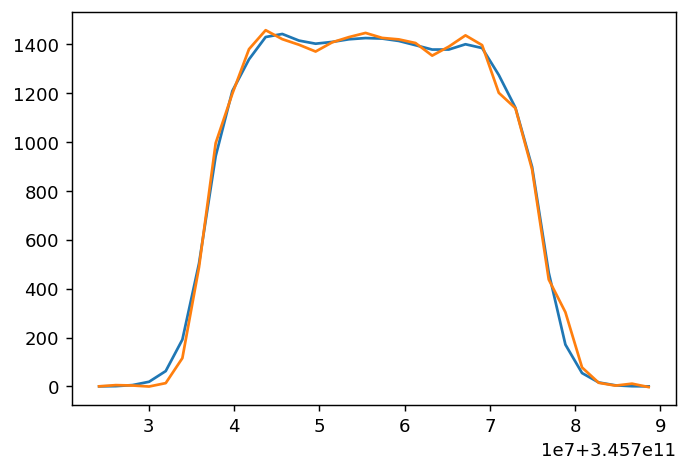

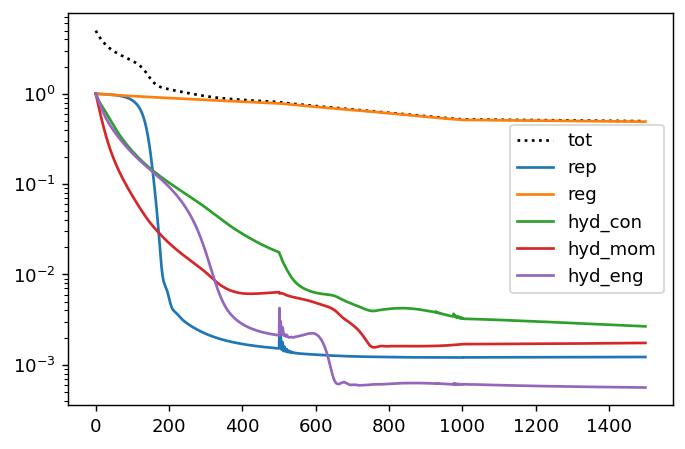

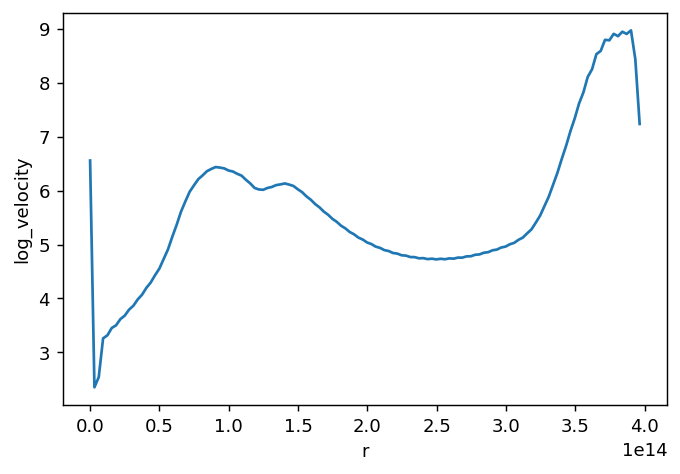

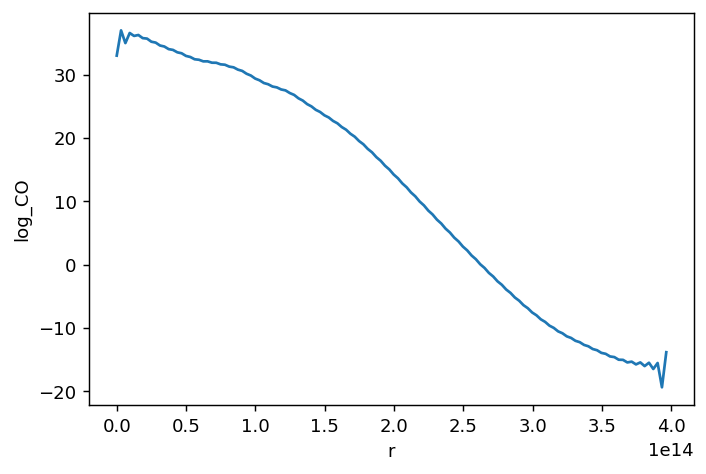

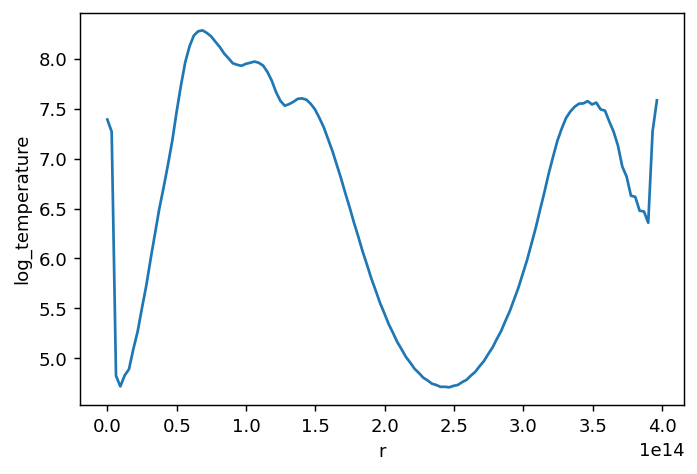

In [52]:
fit(N_epochs=500, lr=1.0e-3, w_rep=1.0/f_rep, w_reg=1.0/f_reg, w_con=1.0/f_con, w_mom=1.0/f_mom, w_eng=1.0/f_eng)

# Plot the loss evolution
loss.plot()
# Plot the resulting model
spherical.plot()

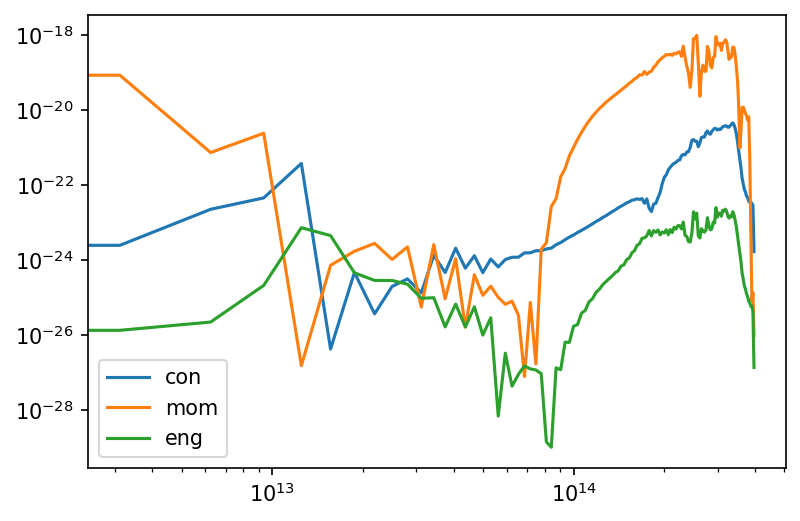

In [28]:
r = spherical.model_1D.get_coords()
L_con, L_mom, L_eng = steady_state_hydrodynamic_loss(spherical).detach().numpy()

plt.figure(dpi=150)
plt.plot(r, L_con, label='con')
plt.plot(r, L_mom, label='mom')
plt.plot(r, L_eng, label='eng')
plt.xscale('log')
plt.yscale('log')
plt.legend()

 49%|████▉     | 49/100 [00:01<00:01, 36.57it/s]


KeyboardInterrupt: 

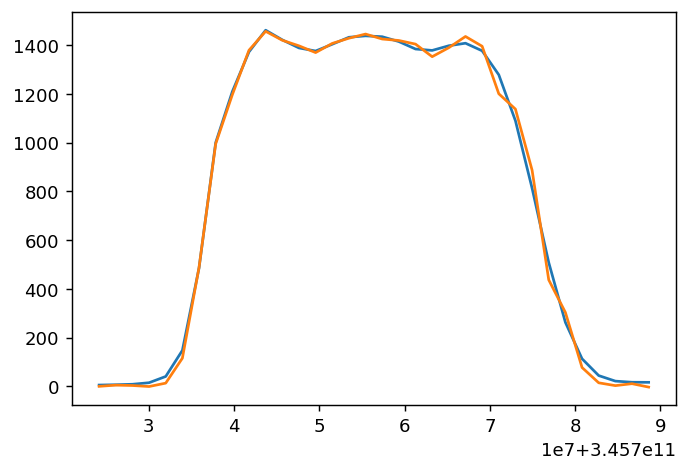

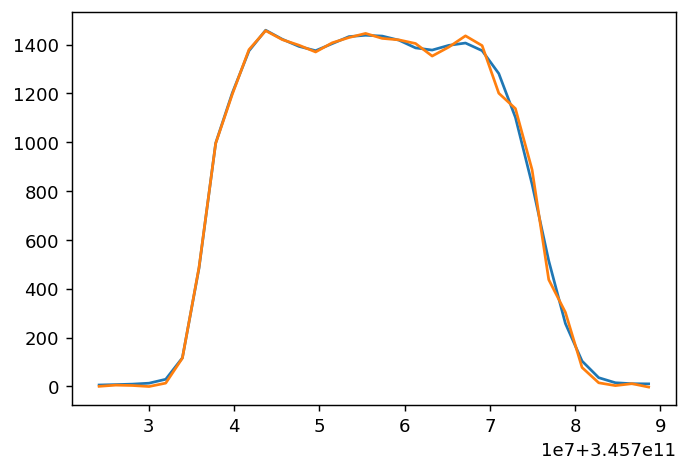

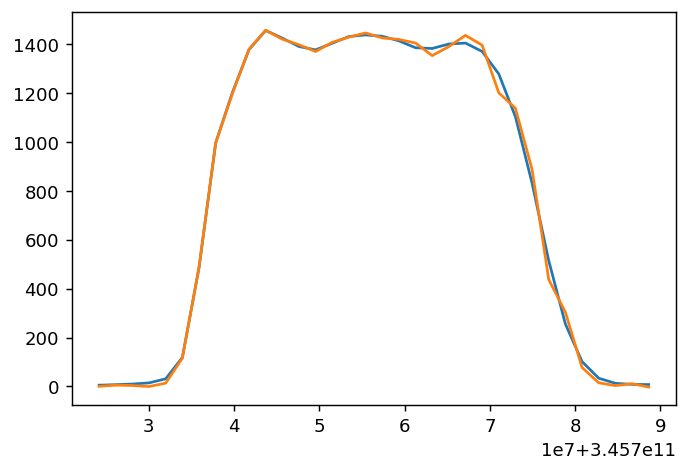

In [ ]:
fit(N_epochs=200, lr=3.0e-1, w_rep=1.0, w_reg=3.0e-2)
fit(N_epochs=200, lr=1.0e-1, w_rep=1.0, w_reg=3.0e-2)
fit(N_epochs=100, lr=5.0e-2, w_rep=1.0, w_reg=3.0e-2)
fit(N_epochs=100, lr=2.0e-2, w_rep=1.0, w_reg=3.0e-2)

# Plot the loss evolution
loss.plot()
# Plot the resulting model
spherical.plot()

In [ ]:
torch.exp(spherical.model_1D['log_v_turbulence'])

tensor([5461.9973], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [ ]:
torch.exp(spherical.model_1D['log_v_los'])

tensor([34962.1721], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [ ]:
model_1D.save("p3droslo_model_1D.hdf5")